This notebook shows how to apply **post-processing** functions on a **SDF** field for **2D** geometries.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from spomso.cores.geom import GenericGeometry

from spomso.cores.helper_functions import generate_grid, smarter_reshape
from spomso.cores.geom_2d import Circle

from spomso.cores.post_processing import custom_post_process
from spomso.cores.post_processing import PostProcess

# FUNCTIONS

In [2]:
def sinc(u, amplitude, width):
    return amplitude*np.sinc(u/width)


post_processing_function_name = "Sinc"

# PARAMETERS

In [3]:
# size of the volume
co_size = 4, 4
# resolution of the volume
co_resolution = 400, 400

show_midplane = True
show_3d = False

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [4]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a **numpy.ndarray** with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

Create some geometry for example a **circle** with radius of **0.8**:

In [5]:
final = Circle(0.8)

# POST-PROCESSING

The **SDF** field can be transformed into other scalar fields with various operations - Including **custom user specified functions**.
This can be done using 3 different approaches:
- **MODIFICATION**: applying a modification to the geometry.
- **FUNCTION**: applying a function to the signed distance field 2D map.
- **OOP**: using the PostProcess class to apply the post-processing to the SDF.
All the approaches are shown below:

There are 7 predefined post-processing functions included in the package. In the examples below the **Gaussian Boundary** post-processing function is used.

## FUNCTION

Evaluate the **SDF** of the geometry to create a signed distance field 2D map:

In [6]:
final_pattern = final.create(coor)

Convert the final pattern into a 2D image:

In [7]:
field = smarter_reshape(final_pattern, co_resolution)

Set the amplitude of the **custom sinc** post-processing function to **1** and the width to **0.5**:

In [8]:
custom_function = custom_post_process(field, sinc, (1.0, 0.5))

## OOP

Create the **PostProcess** class instance and pass the **SDF** of the geometry to the instance:

In [9]:
post_process = PostProcess(final.propagate)

Set the amplitude of the **custom sinc** post-processing function to **1** and the width to **0.5**:

In [10]:
post_process.custom_post_process(sinc, (1.0, 0.5),
                                 post_process_name=post_processing_function_name)

<function spomso.cores.post_processing.PostProcess.custom_post_process.<locals>.new_geo_object(co, *params)>

Create a new geometry from the **post-processed** SDF:

In [11]:
custom_geo = GenericGeometry(post_process.processed_geo_object, ())

Evaluate the **SDF** of the geometry to create a signed distance field 2D map:

In [12]:
custom_geo_field = custom_geo.create(coor)

Convert the map into a 2D image:

In [13]:
custom_oop = smarter_reshape(custom_geo_field, co_resolution)

Print the **post-processing** type:

In [14]:
print("Post-processing type:", post_process.post_processing_operations)

Post-processing type: ['Sinc']


## MODIFICATION

Set the amplitude of the **custom sinc** post-processing function to **1** and the width to **0.5**:

In [15]:
final.custom_post_process(sinc, (1.0, 0.5),
                          post_process_name=post_processing_function_name)

<function spomso.cores.modifications.ModifyObject.custom_post_process.<locals>.new_geo_object(co, *params)>

Evaluate the **SDF** of the geometry to create a signed distance field 2D map:

In [16]:
custom_modification_pattern = final.create(coor)

Convert the map into a 2D image:

In [17]:
custom_modification = smarter_reshape(custom_modification_pattern, co_resolution)

Print the modifications:

In [18]:
print("Modifications:", final.modifications)

Modifications: ['Sinc']


# PLOT

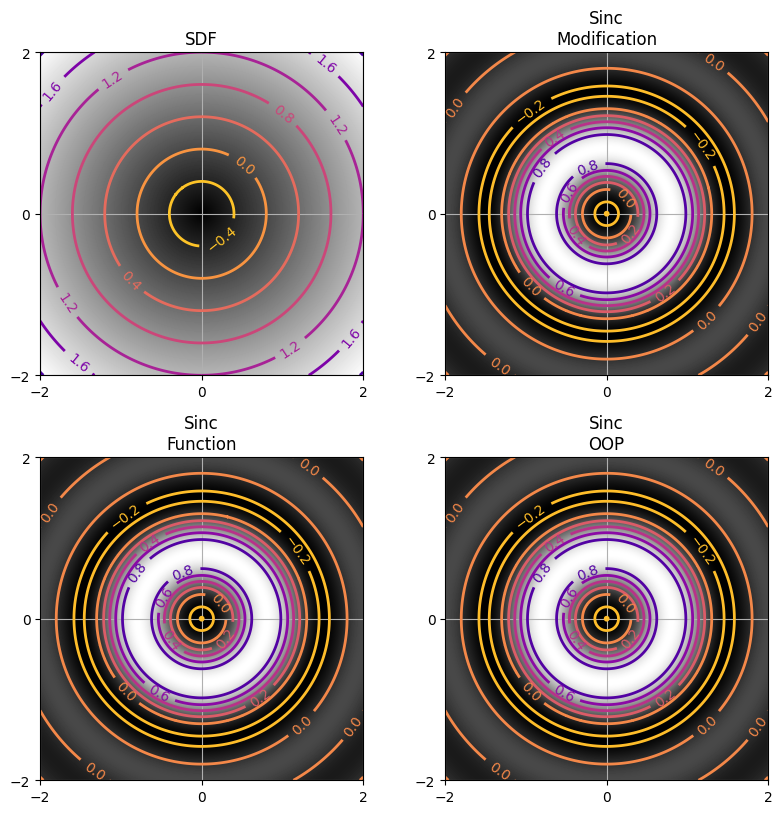

In [19]:
if show_midplane:
    fig, axs = plt.subplots(2, 2, figsize=(8.25, 8.25))

    patterns = ((field, custom_modification), (custom_function, custom_oop))
    titles = (("SDF", f"{post_processing_function_name}\nModification"),
              (f"{post_processing_function_name}\nFunction", f"{post_processing_function_name}\nOOP"))
    for i in range(2):
        for j in range(2):
            ax = axs[i, j]
            ax.imshow(patterns[i][j][:, :].T,
                      cmap="binary_r",
                      extent=(-co_size[0]/2, co_size[0]/2,
                              -co_size[1]/2, co_size[1]/2),
                      origin="lower"
                      )
            cs = ax.contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                            coor[1].reshape(co_res_new[0], co_res_new[1]),
                            patterns[i][j][:, :],
                            cmap="plasma_r",
                            linewidths=2)
            ax.clabel(cs, inline=True, fontsize=10)
            ax.set_xticks(np.linspace(-co_size[0]/2, co_size[0]/2, 3))
            ax.set_yticks(np.linspace(-co_size[1]/2, co_size[1]/2, 3))
            ax.grid()
            ax.set_title(titles[i][j])

    fig.tight_layout()
    plt.show()


if show_3d:
    patterns = ((field, custom_modification), (custom_function, custom_oop))
    titles = ("SDF",
              f"{post_processing_function_name} - Modification",
              f"{post_processing_function_name} - Function",
              f"{post_processing_function_name} - OOP")

    fig = make_subplots(rows=2, cols=2,
                        specs=[[{'is_3d': True}, {'is_3d': True}],
                               [{'is_3d': True}, {'is_3d': True}]],
                        subplot_titles=titles
                        )

    for i in range(2):
        for j in range(2):
            fig.add_trace(go.Surface(x=coor[0].reshape(co_res_new[0], co_res_new[1]),
                                     y=coor[1].reshape(co_res_new[0], co_res_new[1]),
                                     z=patterns[i][j][:, :],
                                     contours={
                                         "z": {"show": True, "start": 0.0, "end": 1, "size": 0.1}
                                     },
                                     cmin=0,
                                     cmax=1),
                          1+i, 1+j,
                          )

            fig.update_traces(contours_z=dict(show=True, usecolormap=False,
                                              highlightcolor="limegreen", project_z=True))

    fig.show()